# <img style="float: left; padding-right: 20px; width: 100px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"> MDS3050-Actividad de Graduación I
**Pontificia Universidad Católica de Chile**<br>
**Magíster en Ciencia de Datos**<br>
**2024**<br>

----

## Estudio inicial del proyecto

__Alumnos:__

|             Nombres            |       Correo       |
|--------------------------------|--------------------|
|Jose Alexander Idarraga Cardona | jaidarragac@uc.cl  |
|Dario Gonzalo Saabedra Contreras| dgsaavedrac@uc.cl  |
|Luis Antonio Aguilar Gutiérrez  | laaguilarg@uc.cl   |

# Introduccion:

El siguiente reporte tiene como finalidad mostrar un avance del estudio inicial realizado con una muestra de los datos a trabajar. Dividimos el dataset en dos grupos: caracterizacion y cursos. El subgrupo de caracterizacion contiene informacion categorica sobre los estudiantes, representada en forma de encuesta. Con este subgrupo se pretende analizar y modelar las relaciones sociales en relacion con el rendimiento academico universitario.

De igual manera, el subgrupo de cursos contiene informacion sobre las evaluaciones, las cuales se dividen en componentes, denotados como `SEQ`. Asimismo se cuenta con el promedio final del curso (`TCKG_GRDE_CODE_FINAL`). El objetivo de trabajo para este subgrupo es explorar la relacion que existe entre los componentes de evaluacion `SEQ` y el rendimiento de los estudiantes, con el proposito de lograr detectar el riesgo de desaprobar en los estudiantes.

El notebook se estructura de la siguiente manera:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import load_data

In [3]:
data = load_data()

# Analisis de subgrupo de cursos

In [52]:
#data

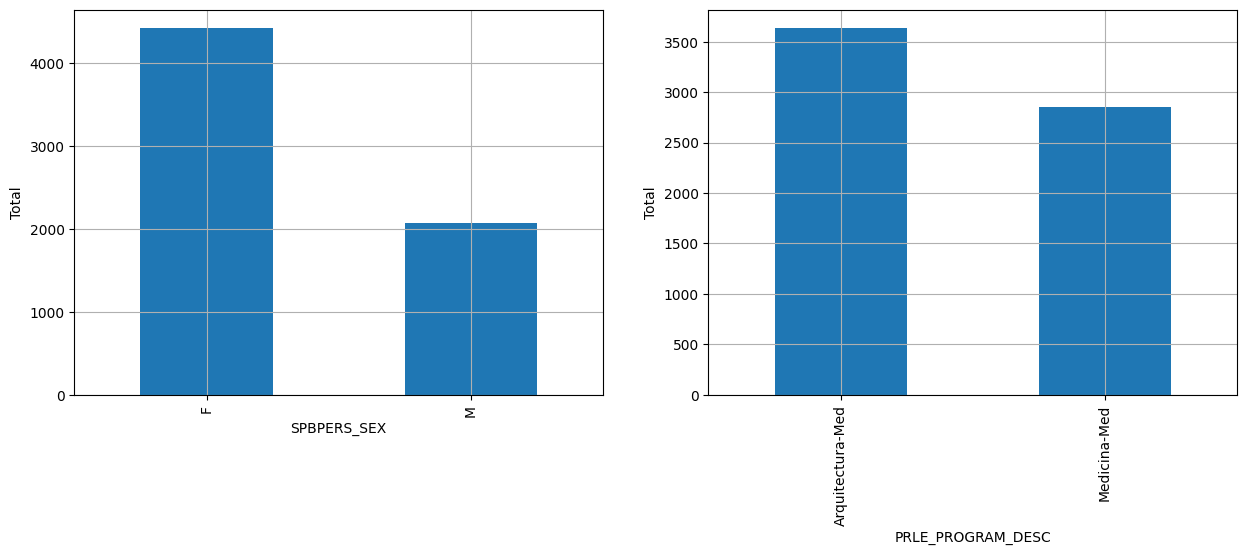

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
data.groupby('SPBPERS_SEX')['CAMPUS'].count().plot(kind = 'bar', ax = ax[0])
data.groupby('PRLE_PROGRAM_DESC')['CAMPUS'].count().plot(kind = 'bar', ax = ax[1])
for k in range(2):
    ax[k].grid();
    ax[k].set_ylabel('Total')

In [7]:
# separate into programs
medicina = data[data['PRLE_PROGRAM_DESC'] == data.PRLE_PROGRAM_DESC.unique()[0]]
arquitectura = data[data['PRLE_PROGRAM_DESC'] == data.PRLE_PROGRAM_DESC.unique()[1]]

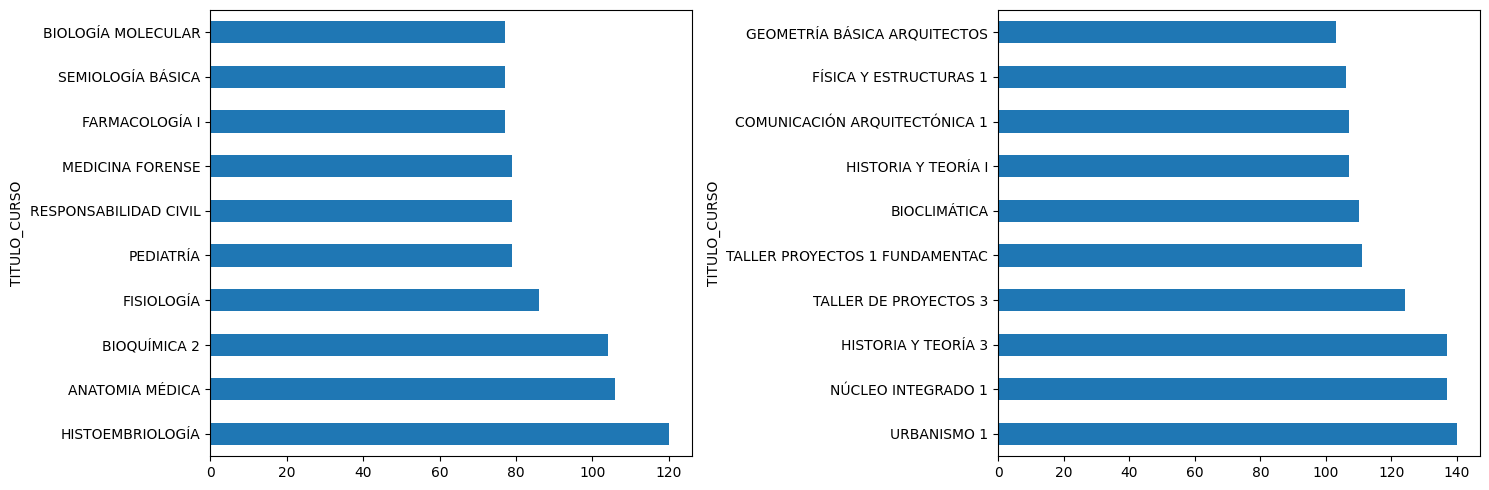

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
medicina.groupby('TITULO_CURSO')['CAMPUS'].count().sort_values(ascending = False).head(10).plot(kind = 'barh', ax = axs[0])
arquitectura.groupby('TITULO_CURSO')['CAMPUS'].count().sort_values(ascending = False).head(10).plot(kind = 'barh', ax = axs[1])
fig.tight_layout()

In [10]:
common_course = 'LENGUA Y CULTURA'

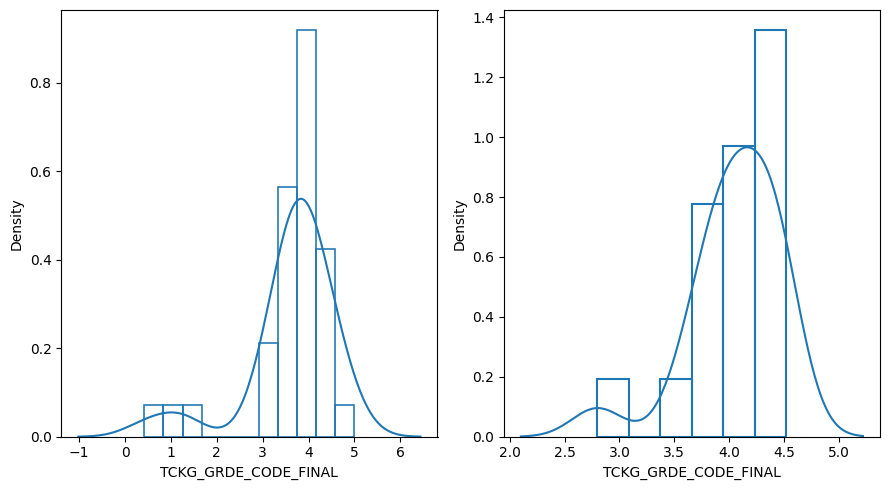

In [11]:
fig, ax = plt.subplots(1, 2 , figsize = (9, 5))
sns.histplot(arquitectura[arquitectura['TITULO_CURSO'] == common_course].iloc[:, 10:].TCKG_GRDE_CODE_FINAL, kde = True, fill = False, stat="density", kde_kws=dict(cut=3), ax = ax[0])#, log_scale = True)
sns.histplot(medicina[medicina['TITULO_CURSO'] == common_course].iloc[:, 10:].TCKG_GRDE_CODE_FINAL, kde = True, fill = False, stat="density", kde_kws=dict(cut=3), ax = ax[1])
fig.tight_layout();
#ax.tick_params(axis='x', rotation=90)

In [12]:
numeric_features = [f'SEQ_{k + 1}' for k in range(20)] + ['TCKG_GRDE_CODE_FINAL']

In [16]:
corr_subset = data[data['TITULO_CURSO'] == common_course].copy()
corr_medicina = corr_subset[corr_subset['PRLE_PROGRAM_DESC'] == corr_subset.PRLE_PROGRAM_DESC.unique()[0]]
corr_arquitectura = corr_subset[corr_subset['PRLE_PROGRAM_DESC'] == corr_subset.PRLE_PROGRAM_DESC.unique()[1]]

In [23]:
corr = corr_subset.loc[:, numeric_features[:10] + [numeric_features[-1]]].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision = 3)

,SEQ_1,SEQ_2,SEQ_3,SEQ_4,SEQ_5,SEQ_6,SEQ_7,SEQ_8,SEQ_9,SEQ_10,TCKG_GRDE_CODE_FINAL
SEQ_1,1.000,0.165,0.394,0.255,0.474,0.371,-0.121,0.072,0.125,0.077,0.740
SEQ_2,0.165,1.000,0.397,0.529,0.150,0.035,-0.047,-0.156,-0.093,-0.129,0.482
SEQ_3,0.394,0.397,1.000,0.426,0.117,0.180,-0.158,-0.454,-0.409,-0.482,0.602
SEQ_4,0.255,0.529,0.426,1.000,0.315,0.259,0.116,-0.139,-0.132,-0.166,0.655
SEQ_5,0.474,0.150,0.117,0.315,1.000,0.685,0.178,0.305,0.228,0.276,0.639
SEQ_6,0.371,0.035,0.180,0.259,0.685,1.000,0.119,0.346,0.250,0.283,0.570
SEQ_7,-0.121,-0.047,-0.158,0.116,0.178,0.119,1.000,0.255,0.161,0.166,0.041
SEQ_8,0.072,-0.156,-0.454,-0.139,0.305,0.346,0.255,1.000,0.829,0.872,0.011
SEQ_9,0.125,-0.093,-0.409,-0.132,0.228,0.250,0.161,0.829,1.000,0.804,0.012
SEQ_10,0.077,-0.129,-0.482,-0.166,0.276,0.283,0.166,0.872,0.804,1.000,-0.044


In [24]:
corr_med = corr_medicina.loc[:, numeric_features[:10] + [numeric_features[-1]]].corr()
corr_med.style.background_gradient(cmap='coolwarm').format(precision = 3)

,SEQ_1,SEQ_2,SEQ_3,SEQ_4,SEQ_5,SEQ_6,SEQ_7,SEQ_8,SEQ_9,SEQ_10,TCKG_GRDE_CODE_FINAL
SEQ_1,1.000,0.234,0.464,0.349,0.208,-0.128,-0.448,0.011,0.098,0.001,0.526
SEQ_2,0.234,1.000,0.410,0.294,-0.325,-0.295,-0.542,-0.256,-0.094,-0.265,0.207
SEQ_3,0.464,0.410,1.000,0.196,-0.077,-0.095,-0.511,-0.343,0.017,-0.328,0.493
SEQ_4,0.349,0.294,0.196,1.000,0.672,0.265,-0.545,-0.031,-0.097,-0.205,0.815
SEQ_5,0.208,-0.325,-0.077,0.672,1.000,0.525,-0.074,0.243,0.059,0.175,0.682
SEQ_6,-0.128,-0.295,-0.095,0.265,0.525,1.000,0.079,0.541,0.244,0.351,0.360
SEQ_7,-0.448,-0.542,-0.511,-0.545,-0.074,0.079,1.000,0.526,0.427,0.420,-0.370
SEQ_8,0.011,-0.256,-0.343,-0.031,0.243,0.541,0.526,1.000,0.773,0.790,0.138
SEQ_9,0.098,-0.094,0.017,-0.097,0.059,0.244,0.427,0.773,1.000,0.573,0.254
SEQ_10,0.001,-0.265,-0.328,-0.205,0.175,0.351,0.420,0.790,0.573,1.000,0.007


In [22]:
corr_arq = corr_arquitectura.loc[:, numeric_features[:10] + [numeric_features[-1]]].corr()
corr_arq.style.background_gradient(cmap='coolwarm').format(precision = 3)

,SEQ_1,SEQ_2,SEQ_3,SEQ_4,SEQ_5,SEQ_6,SEQ_7,SEQ_8,SEQ_9,SEQ_10,TCKG_GRDE_CODE_FINAL
SEQ_1,1.000,0.082,0.376,0.191,0.498,0.387,-0.018,0.097,0.154,0.130,0.754
SEQ_2,0.082,1.000,0.392,0.547,0.228,0.012,0.227,-0.118,-0.091,-0.042,0.511
SEQ_3,0.376,0.392,1.000,0.465,0.144,0.202,-0.010,-0.508,-0.606,-0.535,0.630
SEQ_4,0.191,0.547,0.465,1.000,0.255,0.208,0.276,-0.183,-0.159,-0.148,0.618
SEQ_5,0.498,0.228,0.144,0.255,1.000,0.701,0.288,0.343,0.310,0.336,0.624
SEQ_6,0.387,0.012,0.202,0.208,0.701,1.000,0.150,0.370,0.306,0.334,0.563
SEQ_7,-0.018,0.227,-0.010,0.276,0.288,0.150,1.000,0.069,-0.045,0.015,0.159
SEQ_8,0.097,-0.118,-0.508,-0.183,0.343,0.370,0.069,1.000,0.867,0.922,-0.017
SEQ_9,0.154,-0.091,-0.606,-0.159,0.310,0.306,-0.045,0.867,1.000,0.948,-0.042
SEQ_10,0.130,-0.042,-0.535,-0.148,0.336,0.334,0.015,0.922,0.948,1.000,-0.029


In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
linear_reg = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)

In [38]:
linear_reg.fit(corr_subset.iloc[:, 10:-1], corr_subset.TCKG_GRDE_CODE_FINAL)

LinearRegression()

In [53]:
#corr_subset.iloc[:, 10:-11]

In [45]:
common_course

'LENGUA Y CULTURA'

Notar que como ilustracion estamos entrenando con todos los datos del curso de `Lengua y cultura`, idealmente este proceso tendria que llevarse a cabo de una manera msa rigursa usando estragias de validacion cruzada o validacion simple. Sin embargo, para efectos demostrativos estamos interesados en observar si el modelo puede extraer algun patron util de los datos para la prediccion. Adicionalmente, entrenaremos varios modelos, donde para cad uno de ellos iremos agregando un componente `SEQ` de manera iterativa hasta completar `10` componentes:

In [40]:
linear_reg.score(corr_subset.iloc[:, 10:-1], corr_subset.TCKG_GRDE_CODE_FINAL)

0.9083263571418732

In [41]:
linear_reg.predict(corr_subset.iloc[:, 10:-1])

array([4.61943942, 4.39779247, 4.52328154, 1.20945982, 4.61943942,
       3.83168453, 3.59284628, 4.13808884, 3.01101121, 3.01101121,
       4.83220097, 3.8487077 , 3.34056915, 3.8487077 , 3.75647073,
       3.92016397, 4.12281254, 3.23534655, 3.6179949 , 4.66592297,
       1.82876601, 4.26984261, 3.94384251, 0.52272251, 3.76076592,
       3.66971572, 4.57457847, 3.8477265 , 4.57457847, 3.89079044,
       3.75694622, 4.23722961, 3.0760701 , 4.55302017, 4.5395548 ,
       3.11061472, 4.53506635, 3.78898767, 3.74278228, 4.14587369,
       3.7484883 , 3.29409253, 3.96592013, 3.28322431, 4.08182557,
       4.20368375, 3.9110262 , 3.9110262 , 3.69370717, 3.69370717,
       3.48461729, 4.12625469])

In [42]:
corr_subset.TCKG_GRDE_CODE_FINAL.values

array([4.38, 4.38, 4.41, 1.02, 4.38, 3.91, 3.81, 3.87, 3.06, 3.06, 4.48,
       3.85, 3.82, 3.85, 3.65, 5.  , 4.01, 2.8 , 3.82, 4.42, 1.35, 4.52,
       4.04, 0.42, 3.93, 3.73, 4.57, 4.05, 4.57, 3.88, 3.61, 4.16, 3.13,
       4.54, 4.46, 3.58, 4.44, 3.84, 3.79, 4.1 , 3.85, 3.42, 4.12, 3.34,
       4.27, 4.07, 4.04, 4.04, 3.38, 3.38, 3.61, 3.7 ])

In [51]:
for f in range(10, 21):
    #print(f)
    if f == 10:
        pass
        #print(data.iloc[:, 10].shape)
    else:
        print(corr_subset.iloc[:, 10:f].shape)
        print(corr_subset.iloc[:, 10:f].columns)
        linear_reg = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
        linear_reg.fit(corr_subset.iloc[:, 10:f], corr_subset.TCKG_GRDE_CODE_FINAL)
        print(linear_reg.score(corr_subset.iloc[:, 10:f], corr_subset.TCKG_GRDE_CODE_FINAL))

(52, 1)
Index(['SEQ_1'], dtype='object')
0.5476719406164834
(52, 2)
Index(['SEQ_1', 'SEQ_2'], dtype='object')
0.6812695019776102
(52, 3)
Index(['SEQ_1', 'SEQ_2', 'SEQ_3'], dtype='object')
0.7288979512230654
(52, 4)
Index(['SEQ_1', 'SEQ_2', 'SEQ_3', 'SEQ_4'], dtype='object')
0.8207078075002407
(52, 5)
Index(['SEQ_1', 'SEQ_2', 'SEQ_3', 'SEQ_4', 'SEQ_5'], dtype='object')
0.8882731168908171
(52, 6)
Index(['SEQ_1', 'SEQ_2', 'SEQ_3', 'SEQ_4', 'SEQ_5', 'SEQ_6'], dtype='object')
0.9030352460482193
(52, 7)
Index(['SEQ_1', 'SEQ_2', 'SEQ_3', 'SEQ_4', 'SEQ_5', 'SEQ_6', 'SEQ_7'], dtype='object')
0.9051427822365349
(52, 8)
Index(['SEQ_1', 'SEQ_2', 'SEQ_3', 'SEQ_4', 'SEQ_5', 'SEQ_6', 'SEQ_7', 'SEQ_8'], dtype='object')
0.9054713986750198
(52, 9)
Index(['SEQ_1', 'SEQ_2', 'SEQ_3', 'SEQ_4', 'SEQ_5', 'SEQ_6', 'SEQ_7', 'SEQ_8',
       'SEQ_9'],
      dtype='object')
0.9055260643223572
(52, 10)
Index(['SEQ_1', 'SEQ_2', 'SEQ_3', 'SEQ_4', 'SEQ_5', 'SEQ_6', 'SEQ_7', 'SEQ_8',
       'SEQ_9', 'SEQ_10'],
      dt

En futuras entregas, nos centraremos en desarrollar uno o varios modelos que sean capaces de encotnrar patrones predictivos en todos los cursos del dataset en diferentes carreras.